In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
import numpy as np
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

In [4]:
def STA(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    vSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        vSTS = vSTS + v[i+negshift:i+posshift]*r[i]
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    vSTA = vSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA, vSTA

In [5]:
#main
Tot=300
dt=1./60
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma=4.5
Omega =Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 20/2.12**2
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [6]:
##Choose x and calculate v
x = LPOU  ##HMM or OU or LPOU
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
v=v[1:-1]
# v =np.diff(x)/dt
# v=v[0:-1] #cut ends.  V(n) = X(n) -X(n-1)
x=x[1:-1]
T=T[1:-1]

(0, 5)

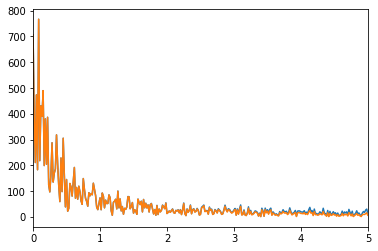

In [7]:
#Fourier analysis 
Ts=dt
xft=fft(OU)
xftreal = xft.real  
xftimg = xft.imag
xft_abs=abs(xft)
xft_nor=xft_abs/len(xft_abs)
xft_nor2=xft_nor[range(int(len(xft_nor)/2))]

f = np.arange(len(xft))
f2 = f[range(int(len(xft)/2))]
f2=f2*Ts
plt.plot(f2,xft_nor2)

xft=fft(LPOU)
xftreal = xft.real  
xftimg = xft.imag
xft_abs=abs(xft)
xft_nor=xft_abs/len(xft_abs)
xft_nor2=xft_nor[range(int(len(xft_nor)/2))]

f = np.arange(len(xft))
f2 = f[range(int(len(xft)/2))]
f2=f2*Ts
plt.plot(f2,xft_nor2)
plt.xlim(0,5)

(140, 160)

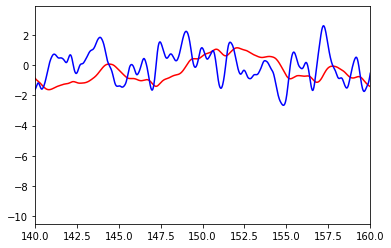

In [8]:
x_n = (x-np.mean(x))/np.std(x)
v_n = (v-np.mean(v))/np.std(v)
plt.plot(T,x_n, 'r-')
plt.plot(T,v_n, 'b-')
plt.xlim(140,160)

0.5333333333333314

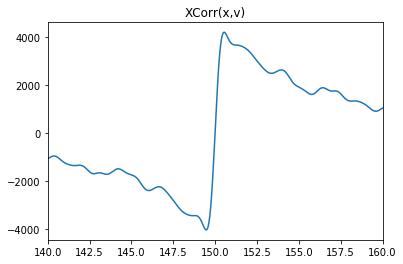

In [9]:
xv_cor = np.correlate(x_n, v_n, "same")
plt.plot(T,xv_cor)
plt.title('XCorr(x,v)')
plt.xlim(140,160)
# Taxis = np.flip(T[:len(xv_cor)]-dt/2)
# t_cor = np.interp(0.5*max(xv_cor),  xv_cor, Taxis)
# t_cor
np.squeeze(T[np.where(xv_cor == max(xv_cor))]-T[np.where(xv_cor == min(xv_cor))])/2

In [10]:
##response
# Model one: simple estimation
# deltaT = 0.5
alpha = 1
beta = 0.5
r = alpha*x+v*beta
#assign states
rstate=np.zeros(len(r))

##'fake distributed'
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)

##'randomly not fire' + 'burst distributed' 
# counter = 0
# burst_distr = np.array([0.95, 0.03, 0.02]);
# for n in np.arange(1,3):
#     edge = np.sort(r)[int(counter)]
#     counter += int(len(r)*burst_distr[n]/(1-burst_distr[0])+0.5)
#     rstate[r>=edge] = n
# randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
# np.random.shuffle(randomly_not_fire)
# rstate = rstate*randomly_not_fire
# rstate = rstate.astype(int)

##equal state
# rstate, edges = EqualState(r, 6)

(0.2916666666666667, -0.14166666666666666, 0.675)

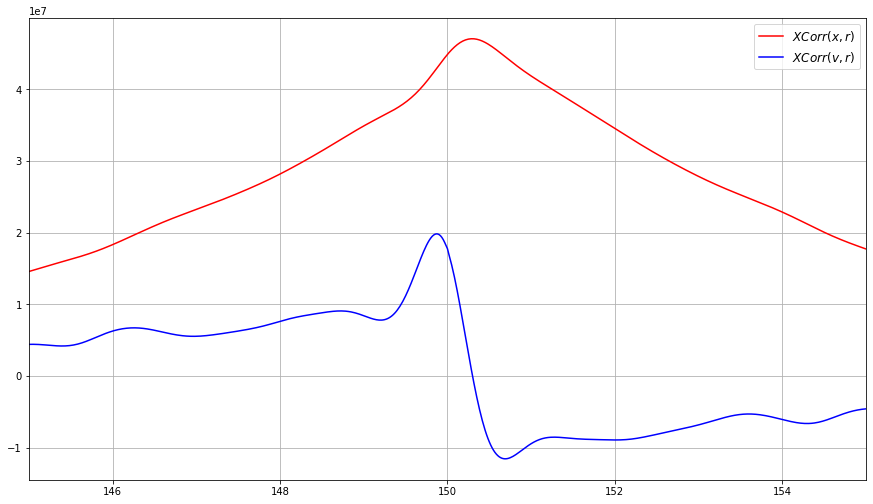

In [11]:
xr_cor = np.correlate(x_n, r, "same")
vr_cor = np.correlate(v_n, r, "same")
plt.plot(T,xr_cor, 'r-')
plt.plot(T,vr_cor, 'b-')
plt.grid()
plt.xlim(145,155)
plt.gcf().set_size_inches(15, 8.5)
plt.legend( (r'$XCorr(x,r)$', r'$XCorr(v,r)$'), loc='best', prop={'size': 'large', 'family': 'monospace'})
(np.squeeze(np.where(xr_cor == max(xr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == max(vr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == min(vr_cor)))-len(T)/2)*dt

In [12]:
#assign states
xstate, edges = EqualState(x, 6)
vstate, edges = EqualState(v, 6)

In [13]:
#calculate STA
window = [-1,1] # second
time, xSTA, vSTA = STA(rstate, x, v, dt, window)

In [14]:
#calculate information
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multi

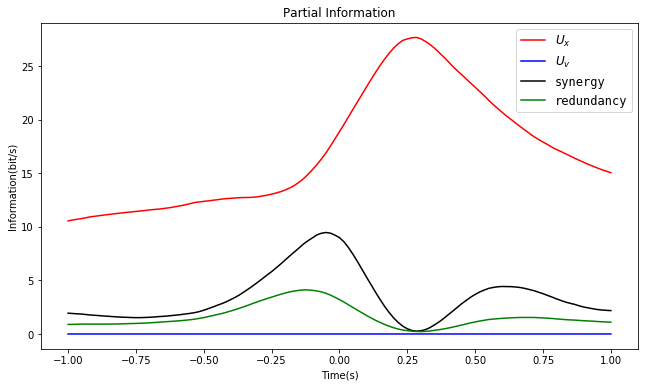

In [15]:
#plot PIs (r,x,v)
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title('Partial Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_PI.tiff')

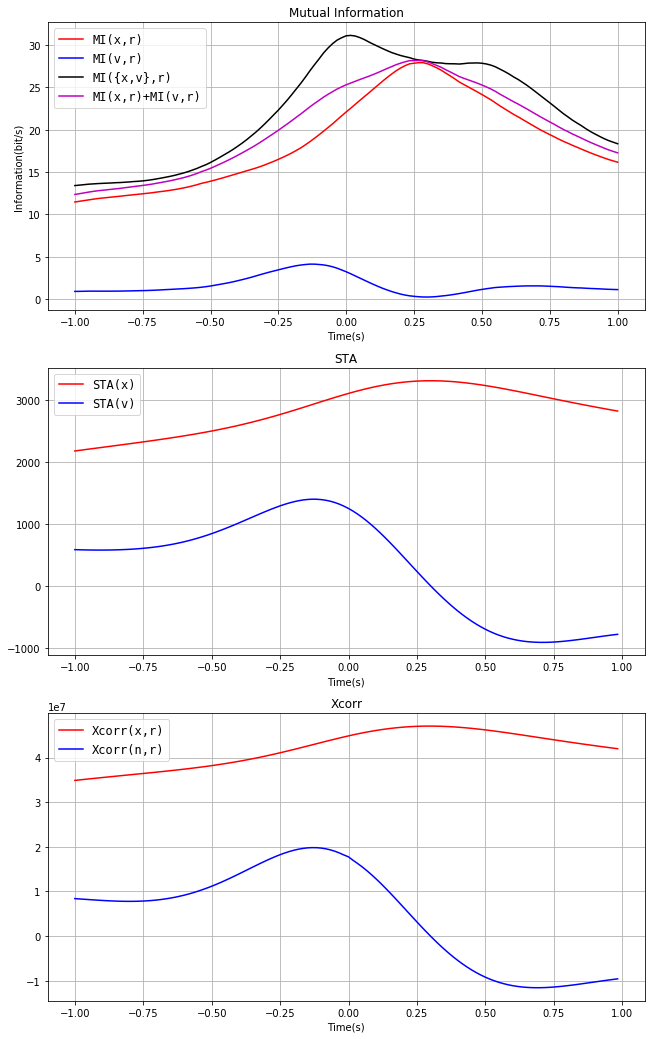

In [16]:
#plot MIs
fig2, (ax2, ax3, ax4) = plt.subplots(nrows=3, ncols=1) 
ax2.plot(timeshift,MIx, 'r-')
ax2.plot(timeshift,MIv, 'b-')
ax2.plot(timeshift,MIjoint, 'k-')
ax2.plot(timeshift,MIx+MIv, 'm-')
ax2.set_title('Mutual Information')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax3.plot(time,xSTA,'r-')
ax3.plot(time,vSTA, 'b-')
ax3.set_title('STA')
ax3.set_xlabel('Time(s)')
ax3.legend( ('STA(x)', 'STA(v)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.plot(time,xr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'r-')
ax4.plot(time,vr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'b-')
ax4.set_title('Xcorr')
ax4.set_xlabel('Time(s)')
ax4.legend( ('Xcorr(x,r)', 'Xcorr(n,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.grid()
ax3.grid()
ax2.grid()
plt.gcf().set_size_inches(10.7, 18)
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')
# plt.ylabel('Information(bit/s)')
# plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [17]:
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot3D(xSTA, vSTA, time, 'gray')

In [18]:
window = [-2,2] # second
timeshift, MIxx, MIxv, MIxjoint, xRedun = PIfunc(xstate, xstate, vstate, dt, window)
Uxx = MIxx-xRedun
Uxv = MIxv-xRedun
xSyner = MIxjoint-MIxx-MIxv+xRedun

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


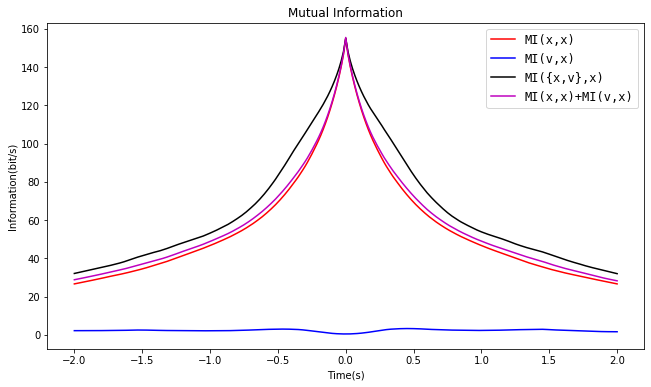

In [19]:
#plot MIs
plt.plot(timeshift,MIxx, 'r-')
plt.plot(timeshift,MIxv, 'b-')
plt.plot(timeshift,MIxjoint, 'k-')
plt.plot(timeshift,MIxx+MIxv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,x)', 'MI(v,x)', 'MI({x,v},x)', 'MI(x,x)+MI(v,x)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multi

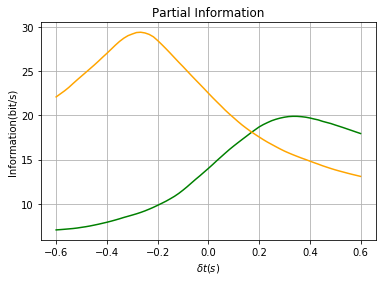

In [20]:
alpha = 1
beta = 1
r = alpha*x+v*beta
#assign states
rstate=np.zeros(len(r))
##'fake distributed'
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, [-0.6, 0.6])
plt.plot(timeshift,MIx, 'g-')

alpha = 1
beta = -0.5
r = alpha*x+v*beta
#assign states
rstate=np.zeros(len(r))
##'fake distributed'
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, [-0.6, 0.6])
plt.plot(timeshift,MIx, color = 'orange')



plt.title('Partial Information')
plt.xlabel(r'$\delta t(s)$')
plt.ylabel('Information(bit/s)')
plt.grid()
plt.savefig('MI_demo.tiff')